## Imports and Utils

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from Environments.windy_gridworld import WindyGridworld

In [2]:

def compute_exact_q(env, gamma=0.9, tol=1e-10):
    """
    Compute exact optimal Q(s,a) for a deterministic gridworld.

    Parameters
    ----------
    env : gridworld-like object
        Must have attributes:
        - env.R, env.C
        - env.reset()
        - env.step(action)
        - env.goal
    gamma : float
        Discount factor.
    tol : float
        Convergence tolerance.

    Returns
    -------
    Q : dict
        Mapping (state, action) -> Q-value
    V : dict
        Mapping state -> V-value
    """

    # Enumerate all states
    states = [(r, c) for r in range(env.R) for c in range(env.C)]
    # Actions: up, right, down, left
    ACTIONS = np.array([
    (-1, 0),  # up
    (0, 1),   # right
    (1, 0),   # down
    (0, -1)   # left
    ])
    actions = list(range(len(ACTIONS)))

    # Initialize V(s) = 0
    V = {s: 0.0 for s in states}
    V[env.goal] = 0.0  # terminal

    # ----- VALUE ITERATION -----
    while True:
        delta = 0.0

        for s in states:
            if s == env.goal:
                continue

            v_old = V[s]
            q_vals = []

            for a in actions:
                env.state = s
                s_next, r, done = env.step(a)

                if done:
                    q = r
                else:
                    q = r + gamma * V[s_next]

                q_vals.append(q)

            V[s] = max(q_vals)
            delta = max(delta, abs(v_old - V[s]))

        if delta < tol:
            break

    # ----- COMPUTE Q FROM V -----
    Q = {}

    for s in states:
        for a in actions:
            if s == env.goal:
                Q[(s, a)] = 0.0
                continue

            env.state = s
            s_next, r, done = env.step(a)

            if done:
                Q[(s, a)] = r
            else:
                Q[(s, a)] = r + gamma * V[s_next]

    return Q, V


In [3]:
def visualize_optimal_path(env, Q_star, V_star, gamma=1.0, max_steps=100):
    """
    Visualize the greedy optimal path induced by Q* / V*.

    Parameters
    ----------
    env : gridworld-like object
    Q_star : dict
        Mapping (state, action) -> Q*
    V_star : dict
        Mapping state -> V*
    gamma : float
        Discount factor used to compute V*
    max_steps : int
        Safety cap against cycles

    Returns
    -------
    path : list of states
    """

    # ---------- Rollout greedy policy ----------
    state = env.reset()
    path = [state]
    # Actions: up, right, down, left
    ACTIONS = np.array([
    (-1, 0),  # up
    (0, 1),   # right
    (1, 0),   # down
    (0, -1)   # left
    ])
    for _ in range(max_steps):
        if state == env.goal:
            break

        # Greedy action from Q*
        q_vals = []
        for a in range(len(ACTIONS)):
            q_vals.append(Q_star[(state, a)])

        best_action = int(np.argmax(q_vals))

        env.state = state
        next_state, _, _ = env.step(best_action)

        # Cycle check (should NEVER happen for correct Q*)
        if next_state in path:
            raise RuntimeError("Cycle detected — Q*/V* inconsistent.")

        path.append(next_state)
        state = next_state

    else:
        raise RuntimeError("Did not reach goal — check Q*/V* correctness.")

    # ---------- Visualization ----------
    fig, ax = plt.subplots(figsize=(env.C * 0.4, env.R * 0.4))

    env.state = env.start
    env.viz(ax=ax, show=False)

    xs = [s[1] for s in path]
    ys = [s[0] for s in path]

    ax.plot(xs, ys, color="black", linewidth=2, marker="o", markersize=4)

    plt.show()

In [4]:
def plot_avg_return_and_regret(avg_returns, avg_regret):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(avg_returns)
    ax[0].set_title("Average Return")
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Return")

    ax[1].plot(avg_regret)
    ax[1].set_title("Average Regret")
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Regret")

    plt.tight_layout()
    plt.show()


## Defining Algorithms

In [5]:
def q_learning(
    env,
    Q_star,
    V_star,
    episodes=2000,
    alpha=0.5,
    gamma=0.9,
    init_from_star=False,
):
    """
    Online Q-learning with eps_k = 1/k.
    Tracks returns and normalized regret using true Q*, V*.

    Parameters
    ----------
    init_from_star : bool
        If True, initialize Q = Q_star (debugging / sanity check)
    """

    states = [(r, c) for r in range(env.R) for c in range(env.C)]
    # Actions: up, right, down, left
    ACTIONS = np.array([
    (-1, 0),  # up
    (0, 1),   # right
    (1, 0),   # down
    (0, -1)   # left
    ])
    actions = range(len(ACTIONS))

    # ----- Initialize Q -----
    if init_from_star:
        Q = Q_star.copy()
    else:
        Q = {(s, a): 0.0 for s in states for a in actions}

    G_star = V_star[env.start]

    returns = np.zeros(episodes)
    avg_returns = np.zeros(episodes)
    avg_regret = np.zeros(episodes)

    # ----- Online learning -----
    for k in range(1, episodes + 1):
        eps = 1.0 / k
        state = env.reset()
        G = 0.0

        while True:
            # ε-greedy
            if np.random.rand() < eps:
                action = np.random.choice(list(actions))
            else:
                qs = [Q[(state, a)] for a in actions]
                action = int(np.argmax(qs))

            next_state, reward, done = env.step(action)
            G += reward

            # Q-learning update
            if done:
                target = reward
            else:
                target = reward + gamma * max(Q[(next_state, a)] for a in actions)

            Q[(state, action)] += alpha * (target - Q[(state, action)])
            state = next_state

            if done:
                break

        returns[k - 1] = G
        avg_returns[k - 1] = returns[:k].mean()
        avg_regret[k - 1] = G_star - avg_returns[k - 1]

    return returns, avg_returns, avg_regret

In [6]:
class AnytimeCOCO:
    """
    Implementation of the Anytime Online Policy for COCO (Algorithm 2) 
    from 'Optimal Anytime Algorithms for Online Convex Optimization with Adversarial Constraints'.
    
    This algorithm achieves O(sqrt(t)) regret and O(sqrt(t)) cumulative constraint violation (CCV)
    without knowing the time horizon T in advance (Anytime property).
    
    Attributes:
        D (float): Diameter of the decision set X.
        G (float): Upper bound on the L2 norm of gradients for cost and constraint functions.
        alpha (float): Scaling factor (2GD)^-1 .
        projection_func (callable): Function that projects a vector onto the convex set X.
        x (np.ndarray): The current action vector x_t.
        t (int): The current time step t.
        Q (float): The virtual queue value Q(t) representing constraint violations.
        sum_grad_sq (float): Cumulative sum of squared norms of surrogate gradients (for AdaGrad).
        lambda_prev (float): The value of lambda from the previous time step (lambda_{t-1}).
    """

    def __init__(self, x1, D, G, projection_func):
        """
        Initializes the Anytime COCO algorithm.

        Args:
            x1 (np.ndarray): Initial feasible action x_1.
            D (float): Diameter of the decision set X.
            G (float): Lipschitz constant (gradient norm bound).
            projection_func (callable): A function that takes a numpy array and returns 
                                        its Euclidean projection onto the set X.
        """
        self.x = np.array(x1, dtype=float)
        self.D = D
        self.G = G
        self.projection_func = projection_func
        
        # Pre-processing parameter alpha = (2GD)^-1  
        self.alpha = 1.0 / (2.0 * G * D)
        
        # Initialization
        self.t = 1
        self.Q = 0.0  # Q(0) = 0  
        self.sum_grad_sq = 0.0 # For AdaGrad step size
        self.lambda_prev = None 

    def get_action(self):
        """
        Returns the current action x_t to be played in round t.
        """
        return self.x

    def _compute_lambda(self, t):
        """
        Computes the time-varying Lyapunov parameter lambda_t according to Eq (15) / Algorithm 2.
        
        lambda_t = 1 / (4 * sqrt(t) * sqrt(log(t)+1) * (log(log(t)+1) + 1)) 
        """
        # Using numpy log for natural logarithm
        log_t_plus_1 = np.log(t) + 1
        term1 = 4.0 * np.sqrt(t)
        term2 = np.sqrt(log_t_plus_1)
        term3 = np.log(log_t_plus_1) + 1
        
        return 1.0 / (term1 * term2 * term3)

    def update(self, cost_grad, constraint_val, constraint_grad):
        """
        Updates the algorithm state based on the feedback from round t.
        
        Args:
            cost_grad (np.ndarray): Gradient of cost function f_t at x_t.
            constraint_val (float): Value of constraint function g_t(x_t).
            constraint_grad (np.ndarray): Gradient of constraint function g_t at x_t.
        """
        # --- 1. Pre-processing   ---
        # Scale functions by alpha. 
        # The constraint is clipped: g_tilde = alpha * max(0, g_t(x))
        
        tilde_f_grad = self.alpha * np.array(cost_grad)
        
        # Handle the max(0, g_t(x)) for the constraint
        if constraint_val > 0:
            tilde_g_val = self.alpha * constraint_val
            tilde_g_grad = self.alpha * np.array(constraint_grad)
        else:
            tilde_g_val = 0.0
            tilde_g_grad = np.zeros_like(constraint_grad)

        # --- 2. Calculate Lambda_t  ---
        lambda_t = self._compute_lambda(self.t)

        # --- 3. Update Virtual Queue Q(t)  ---
        # Q(t) = (lambda_{t-1} / lambda_t) * Q(t-1) + tilde_g_t(x_t)
        # Note: For t=1, Q(0)=0 so the ratio term is 0.
        if self.t == 1:
            self.Q = tilde_g_val
        else:
            # We use the multiplicative factor to ensure monotonicity of Phi_t(Q(t))
            ratio = self.lambda_prev / lambda_t
            self.Q = (ratio * self.Q) + tilde_g_val

        # --- 4. Construct Surrogate Cost Gradient  ---
        # hat_f_t(x) = tilde_f_t(x) + Phi'_t(Q(t)) * tilde_g_t(x)
        # Gradient: grad(hat_f) = grad(tilde_f) + Phi'_t(Q(t)) * grad(tilde_g)
        # Lyapunov derivative: Phi'_t(x) = lambda_t * exp(lambda_t * x) 
        
        phi_prime = lambda_t * np.exp(lambda_t * self.Q)
        hat_f_grad = tilde_f_grad + (phi_prime * tilde_g_grad)

        # --- 5. AdaGrad Step (Algorithm 1)  ---
        # Update cumulative gradient norm squares for adaptive step size
        grad_norm_sq = np.sum(hat_f_grad**2)
        self.sum_grad_sq += grad_norm_sq

        # Compute step size eta_t 
        # eta_t = (sqrt(2) * D) / (2 * sqrt(sum_tau ||grad_tau||^2))
        if self.sum_grad_sq <= 0:
            eta_t = 0.0 # Handle case if gradient is zero initially
        else:
            eta_t = (np.sqrt(2) * self.D) / (2.0 * np.sqrt(self.sum_grad_sq))

        # OGD Update: x_{t+1} = Proj(x_t - eta_t * grad_t)
        unprojected_x = self.x - (eta_t * hat_f_grad)
        self.x = self.projection_func(unprojected_x)

        # --- 6. Advance Time ---
        self.lambda_prev = lambda_t
        self.t += 1

A small test for checking the COCO algo. Use look at cases where constraints are planes normal to standard bases and pases through the origin. $f_t$ is generated randomly. Origin is taken as the base comaprator. This is ofcourse not proof of corectness but ok 

Starting Robustness Test: T=1000, Dimension d=1000...
 Theoretical Diameter D: 63.25


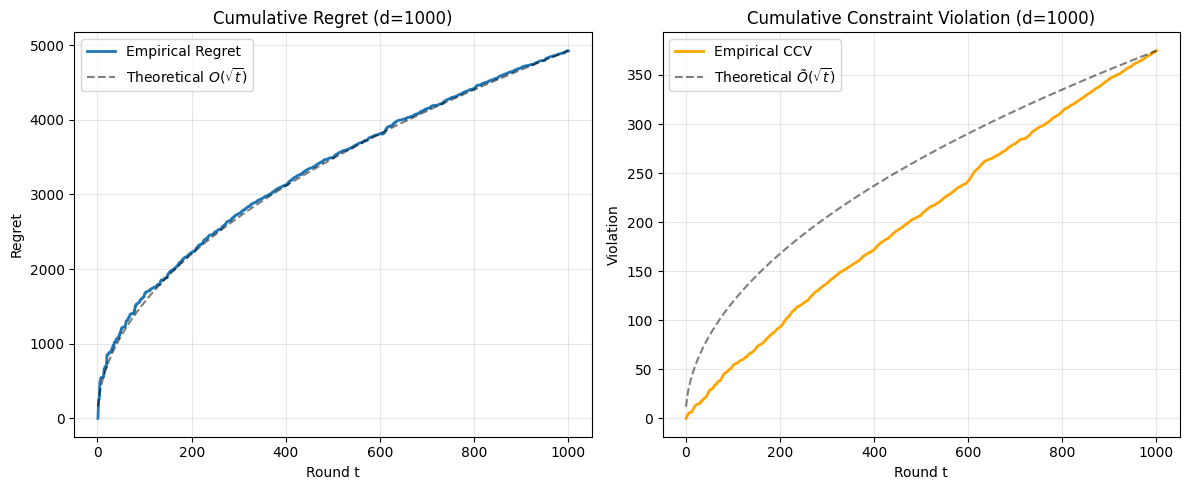

Final Results: {'final_regret': np.float64(4924.734216303232), 'final_ccv': np.float64(374.6987607264942)}


In [7]:
def coco_test(
    T=1000,
    G=10.0,          # Gradient bound guess
    box_radius=1.0,  # Constraint box [-1, 1]
    seed=42,
):
    """
    Run an adversarial Anytime COCO experiment where dimension d = T.
    
    This tests robustness against high dimensionality, where the diameter D
    of the decision set grows with sqrt(T).
    
    Assumes AnytimeCOCO class is available in the scope.
    """
    
    # --- Robustness Config: Set d = T ---
    d = T 
    print(f"Starting Robustness Test: T={T}, Dimension d={d}...")

    rng = np.random.default_rng(seed)
    
    # 1. Calculate theoretical Diameter D for a hypercube of radius R in d dimensions
    # Diagonal distance = sqrt(sum((R - (-R))^2)) = sqrt(d * (2R)^2) = 2R * sqrt(d)
    D_theoretical = 2.0 * box_radius * np.sqrt(d)
    print(f" Theoretical Diameter D: {D_theoretical:.2f}")
    
    # Feasible comparator (the origin)
    x_star = np.zeros(d) 
    
    # Initial point (origin)
    x1 = np.zeros(d)

    def projection_func(x):
        return np.clip(x, -box_radius, box_radius)

    # Initialize the solver with the SCALED Diameter
    # NOTE: Assumes AnytimeCOCO is defined in your scope
    coco = AnytimeCOCO(x1=x1, D=D_theoretical, G=G, projection_func=projection_func)

    # Metrics
    instant_regret = []
    instant_violation = []

    for t in range(1, T + 1):
        xt = coco.get_action()

        # ---------------------------
        # A. Random Convex Cost f_t
        # ---------------------------
        ftype = rng.integers(3)
        
        # Note: In high dimensions, L2 norms grow large. We normalize random vectors 
        # to keep gradients roughly within the expected bound G.
        
        if ftype == 0: # Quadratic well
            # Random center, normalized to stay inside/near box
            c_t = rng.normal(0, 1.0, size=d)
            norm_c = np.linalg.norm(c_t)
            if norm_c > 1e-9:
                c_t = c_t / norm_c * box_radius 
            
            f_val_xt = 0.5 * np.sum((xt - c_t)**2)
            f_val_star = 0.5 * np.sum((x_star - c_t)**2)
            grad_f = xt - c_t

        elif ftype == 1: # Linear loss
            w_t = rng.normal(0, 1.0, size=d)
            norm_w = np.linalg.norm(w_t)
            if norm_w > 1e-9:
                w_t = w_t / norm_w * G # Scale to G
            
            f_val_xt = np.dot(w_t, xt)
            f_val_star = np.dot(w_t, x_star)
            grad_f = w_t

        else: # Diagonal Quadratic
            A = rng.uniform(0.1, 1.0, size=d)
            # Offset normalized
            offset = rng.uniform(-0.5, 0.5, size=d)
            
            diff_xt = xt - offset
            diff_star = x_star - offset
            
            f_val_xt = 0.5 * np.sum(A * diff_xt**2)
            f_val_star = 0.5 * np.sum(A * diff_star**2)
            grad_f = A * diff_xt

        # ---------------------------
        # B. Adversarial Constraint g_t
        # ---------------------------
        # Pick the dimension with max violation to punish the algorithm
        idx = np.argmax(xt)
        g_val = xt[idx]
        
        grad_g = np.zeros(d)
        grad_g[idx] = 1.0

        # ---------------------------
        # C. Record & Update
        # ---------------------------
        instant_regret.append(f_val_xt - f_val_star)
        instant_violation.append(max(0.0, g_val))

        coco.update(cost_grad=grad_f, constraint_val=g_val, constraint_grad=grad_g)

    # ---------------------------
    # Plotting
    # ---------------------------
    cum_regret = np.cumsum(instant_regret)
    cum_ccv = np.cumsum(instant_violation)
    time_steps = np.arange(1, T + 1)
    
    # Baselines
    sqrt_t = np.sqrt(time_steps)
    scale_reg = cum_regret[-1] / sqrt_t[-1]
    scale_ccv = cum_ccv[-1] / sqrt_t[-1] if cum_ccv[-1] > 0 else 1.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Regret
    ax1.plot(time_steps, cum_regret, label='Empirical Regret', linewidth=2)
    ax1.plot(time_steps, scale_reg * sqrt_t, 'k--', alpha=0.5, label=r'Theoretical $O(\sqrt{t})$')
    ax1.set_title(f"Cumulative Regret (d={d})")
    ax1.set_xlabel("Round t")
    ax1.set_ylabel("Regret")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: CCV
    ax2.plot(time_steps, cum_ccv, label='Empirical CCV', color='orange', linewidth=2)
    ax2.plot(time_steps, scale_ccv * sqrt_t, 'k--', alpha=0.5, label=r'Theoretical $\tilde{O}(\sqrt{t})$')
    ax2.set_title(f"Cumulative Constraint Violation (d={d})")
    ax2.set_xlabel("Round t")
    ax2.set_ylabel("Violation")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "final_regret": cum_regret[-1],
        "final_ccv": cum_ccv[-1]
    }


results = coco_test(T=1000, G=10.0, box_radius=1.0)
print("Final Results:", results)

## Initial Q Learning Tests to Get Baseline

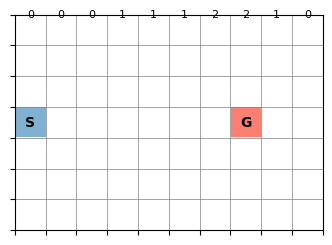

(<Figure size 400x280 with 1 Axes>, <Axes: >)

In [8]:
env1=WindyGridworld()
env1.reset()
env1.viz()

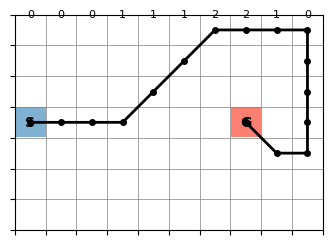

In [9]:
env = WindyGridworld()
Q_star,V_star = compute_exact_q(env)
visualize_optimal_path(WindyGridworld(), Q_star,V_star,gamma=0.9)



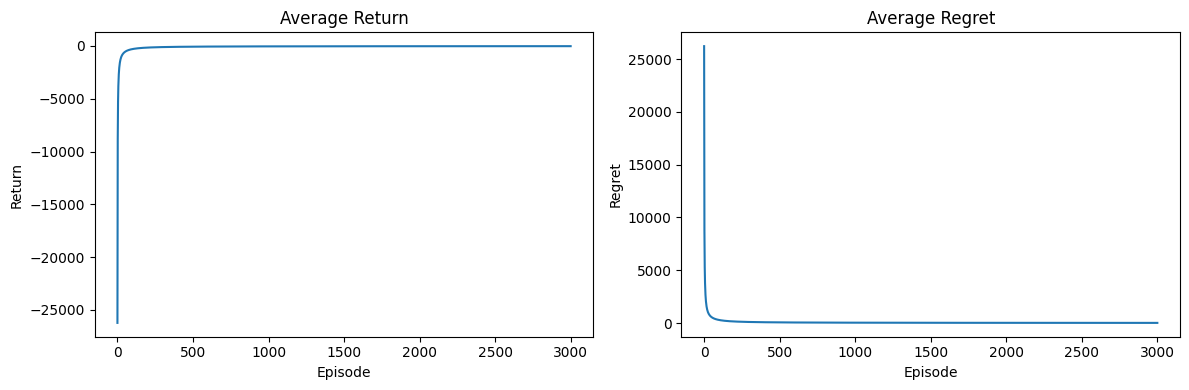

In [10]:

# Run online learning
returns, avg_returns, avg_regret = q_learning(
    env,
    Q_star,
    V_star,
    episodes=3000,
    alpha=0.5,
    init_from_star=False  # set True to sanity-check theory
)

# Plot
plot_avg_return_and_regret(avg_returns, avg_regret)

## RL with COCO 

Check against random policy in Gridworld

Computing Ground Truth (DP with Env Interaction)...
DP Converged in 180 iterations
Running Comparison (TD vs COCO)...


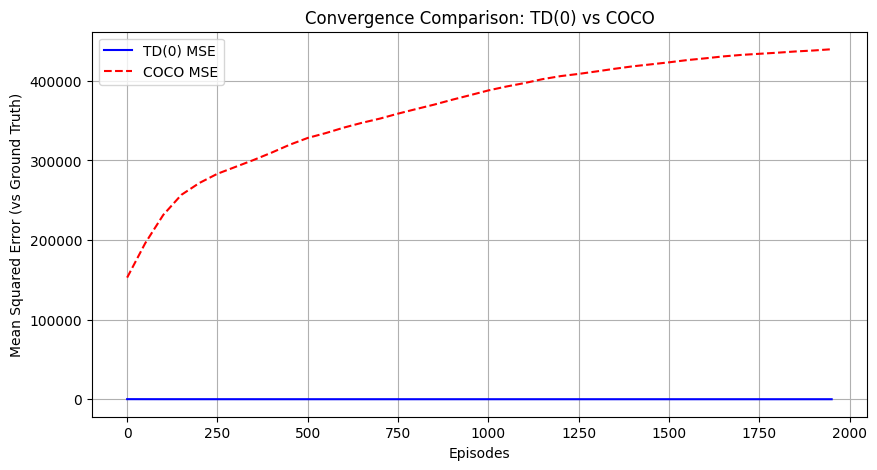

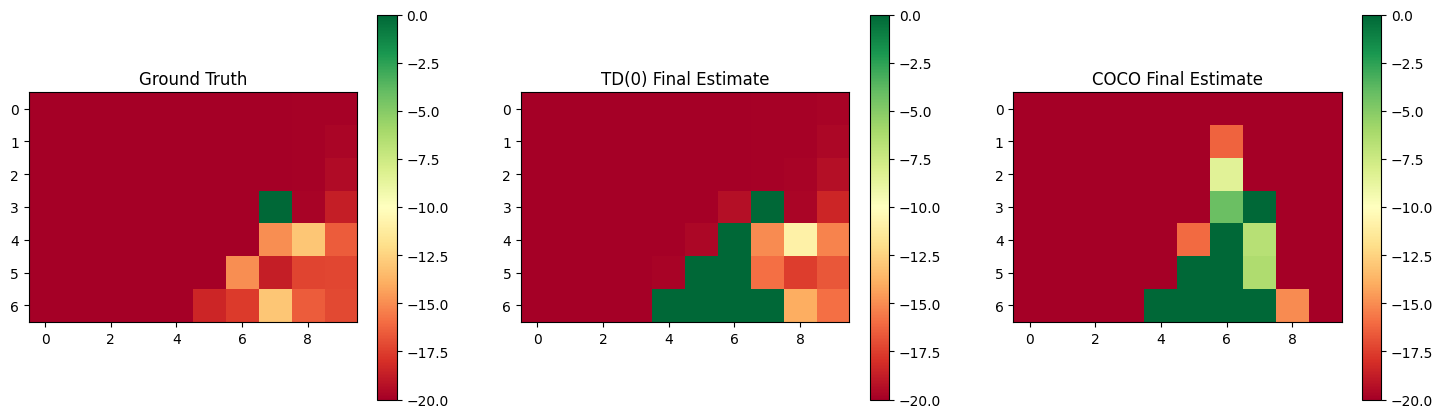

In [75]:
env = WindyGridworld()
S = env.R * env.C
gamma = 0.95
dim = S

print("Computing Ground Truth (DP with Env Interaction)...")

V_true = np.zeros((env.R, env.C))
policy_prob = 0.25

for i in range(1000):
    v_new = np.copy(V_true)
    delta = 0
    for r in range(env.R):
        for c in range(env.C):
            # Skip Goal State
            if (r, c) == env.goal: 
                v_new[r, c] = 0.0
                continue
            
            val_sum = 0
            for a in range(4):
                # A. Set the environment to the current state (Query Mode)
                env.state = (r, c)
                
                # B. Ask environment for the transition
                # Note: This modifies env.state, which is why we reset it 
                # at the start of every inner action loop.
                next_state, reward, done = env.step(a)
                
                # C. Calculate Expectation
                nr, nc = next_state
                v_next = 0.0 if done else V_true[nr, nc]
                val_sum += policy_prob * (reward + gamma * v_next)
            
            v_new[r, c] = val_sum
            delta = max(delta, abs(v_new[r, c] - V_true[r, c]))
            
    V_true = v_new
    if delta < 1e-4: 
        print(f"DP Converged in {i} iterations")
        break

# 2. TD(0) Learner
V_td = np.zeros(dim)
alpha_td = 0.1

# 3. COCO Learner
def domain_proj(x): return np.clip(x, -1000.0, 0.0)
x_init = np.zeros(dim)
coco_td = AnytimeCOCO(x1=x_init, D=100.0, G=2.0, projection_func=domain_proj)

# Metrics
mse_td_history = []
mse_coco_history = []

print("Running Comparison (TD vs COCO)...")
episodes = 2000

for k in range(1, episodes + 1):
    state = env.reset()
    done = False
    steps = 0
    
    while not done and steps < 500:
        r, c = state
        s_idx = r * env.C + c
        
        # Random Action
        action = np.random.randint(4)
        next_state, reward, done = env.step(action)
        nr, nc = next_state
        ns_idx = nr * env.C + nc
        
        # --- A. TD(0) Update ---
        v_curr_td = V_td[s_idx]
        v_next_td = 0.0 if done else V_td[ns_idx]
        td_target = reward + gamma * v_next_td
        V_td[s_idx] += alpha_td * (td_target - v_curr_td)
        
        # --- B. COCO Update ---
        # 1. Objective: Minimize V (grad_f = 1 at s_idx)
        grad_f = np.zeros(dim)
        grad_f[s_idx] = 1.0
        
        # 2. Constraint: V(s) >= r + gamma * V(s')
        v_curr_coco = coco_td.x[s_idx]
        v_next_coco = 0.0 if done else coco_td.x[ns_idx]
        target_coco = reward + gamma * v_next_coco
        
        g_val = target_coco - v_curr_coco # Violation magnitude
        
        grad_g = np.zeros(dim)
        grad_g[s_idx] = -1.0
        if not done: grad_g[ns_idx] = gamma
            
        coco_td.update(grad_f, g_val, grad_g)
        
        state = next_state
        steps += 1
    
    # Record MSE every 50 episodes
    if k % 50 == 0:
        V_coco_grid = coco_td.x.reshape(env.R, env.C)
        V_td_grid = V_td.reshape(env.R, env.C)
        
        mse_td = np.mean((V_true - V_td_grid)**2)
        mse_coco = np.mean((V_true - V_coco_grid)**2)
        
        mse_td_history.append(mse_td)
        mse_coco_history.append(mse_coco)

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(range(0, episodes, 50), mse_td_history, label='TD(0) MSE', color='blue')
plt.plot(range(0, episodes, 50), mse_coco_history, label='COCO MSE', color='red', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Mean Squared Error (vs Ground Truth)')
plt.title('Convergence Comparison: TD(0) vs COCO')
plt.legend()
plt.grid(True)
plt.show()

# Final Heatmap Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(V_true, cmap='RdYlGn', vmin=-20, vmax=0)
axes[0].set_title("Ground Truth")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(V_td.reshape(env.R, env.C), cmap='RdYlGn', vmin=-20, vmax=0)
axes[1].set_title("TD(0) Final Estimate")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(coco_td.x.reshape(env.R, env.C), cmap='RdYlGn', vmin=-20, vmax=0)
axes[2].set_title("COCO Final Estimate")
plt.colorbar(im2, ax=axes[2])

plt.show()

Starting COCO Training (Maximize Reward Formulation)...
Episode 50: Reward -500.0
Episode 100: Reward -500.0
Episode 150: Reward -500.0
Episode 200: Reward -500.0
Episode 250: Reward -500.0
Episode 300: Reward -500.0
Episode 350: Reward -500.0
Episode 400: Reward -500.0
Episode 450: Reward -500.0
Episode 500: Reward -500.0

Tracing Greedy Path...
Path Length: 50


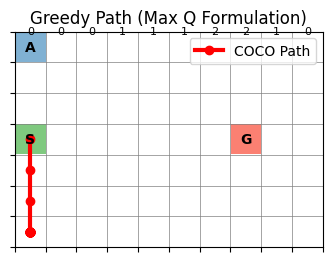

In [74]:
# 1. Setup Environment
env = WindyGridworld()
S = env.R * env.C
A = 4
dim = S * A

# 2. Setup COCO with "Maximize Q" Configuration
# We want to maximize Q, so we set bounds to allow negative values (up to 0).
# Unvisited states initialized at 0.0 will naturally be preferred (Optimism).
def domain_proj(x):
    return np.clip(x, -1000.0, 0.0)

x_init = np.zeros(dim)

coco = AnytimeCOCO(
    x1=x_init, 
    D=100.0,  
    G=2.0,    
    projection_func=domain_proj
)

# Helper for indexing
def to_idx(r, c):
    return r * env.C + c

# 3. Training Loop
episodes = 500
gamma = 0.95
rewards_history = []

print("Starting COCO Training (Maximize Reward Formulation)...")

for k in range(1, episodes + 1):
    state = env.reset()
    s_idx = to_idx(*state)
    done = False
    total_reward = 0
    steps = 0
    
    # Decaying exploration
    epsilon = 1.0 / k
    
    while not done and steps < 500:
        # Get current Q-table
        q_table = coco.x.reshape(S, A)
        
        # A. Action Selection
        if np.random.rand() < epsilon:
            action = np.random.randint(A)
        else:
            action = np.argmax(q_table[s_idx])
            
        next_state, reward, done = env.step(action)
        ns_idx = to_idx(*next_state)
        
        # --- B. COCO Update (Sub-solution / Maximize Q) ---
        
        # 1. Objective: Maximize Q(s,a)
        grad_f = np.zeros(dim)
        flat_idx_sa = s_idx * A + action
        grad_f[flat_idx_sa] = -1.0 
        
        # 2. Constraint: Q(s,a) <= r + gamma * max Q(s')
        # This acts as the "ceiling" to stop Q from going to infinity.
        # Standard Form g(x) <= 0:  Q(s,a) - (r + gamma * Q_next) <= 0
        
        q_current = q_table[s_idx, action]
        
        if done:
            q_next_max = 0.0
            flat_idx_next = -1
        else:
            q_next_max = np.max(q_table[ns_idx])
            best_next_a = np.argmax(q_table[ns_idx])
            flat_idx_next = ns_idx * A + best_next_a
            
        target = reward + gamma * q_next_max
        
        # Violation: If Q > target, then g_val > 0.
        g_val = target-q_current 
        
        # Gradients of g(x) = Q(s,a) - ...
        grad_g = np.zeros(dim)
        grad_g[flat_idx_sa] = -1.0       # d(g)/dQ(s,a) = 1
        
    
            
        # 3. Update
        coco.update(grad_f, g_val, grad_g)
        
        # Transition
        state = next_state
        s_idx = ns_idx
        total_reward += reward
        steps += 1
        
    rewards_history.append(total_reward)
    if k % 50 == 0:
        print(f"Episode {k}: Reward {total_reward:.1f}")

# 4. Visualization
print("\nTracing Greedy Path...")
path = [env.reset()]
done = False
steps = 0
q_final = coco.x.reshape(S, A)

while not done and steps < 50:
    s_curr = path[-1]
    s_idx = to_idx(*s_curr)
    a = np.argmax(q_final[s_idx])
    ns, _, done = env.step(a)
    path.append(ns)
    steps += 1

print(f"Path Length: {len(path)-1}")
env.viz(show=False)
rows, cols = zip(*path)
# Invert rows for plotting
rows_plot = [env.R - 1 - r for r in rows]
plt.plot(cols, rows_plot, color='red', linewidth=3, marker='o', label='COCO Path')
plt.title("Greedy Path (Max Q Formulation)")
plt.legend()
plt.show()